## GMMs for time series

To illustrate the `scsgmm` API, fit a GMM time series model to some example data from `statsmodels` and simulate from it.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Import the custom classes:

In [2]:
from scsgmm import GaussianMixture, SCSGMM

#### Univariate example

Load sunspot data:

In [3]:
sspot = sm.datasets.sunspots.load_pandas().data.astype(int).set_index('YEAR')
print(sspot.shape)
sspot.head(3)

(309, 1)


,SUNACTIVITY
YEAR,
1700,5
1701,11
1702,16


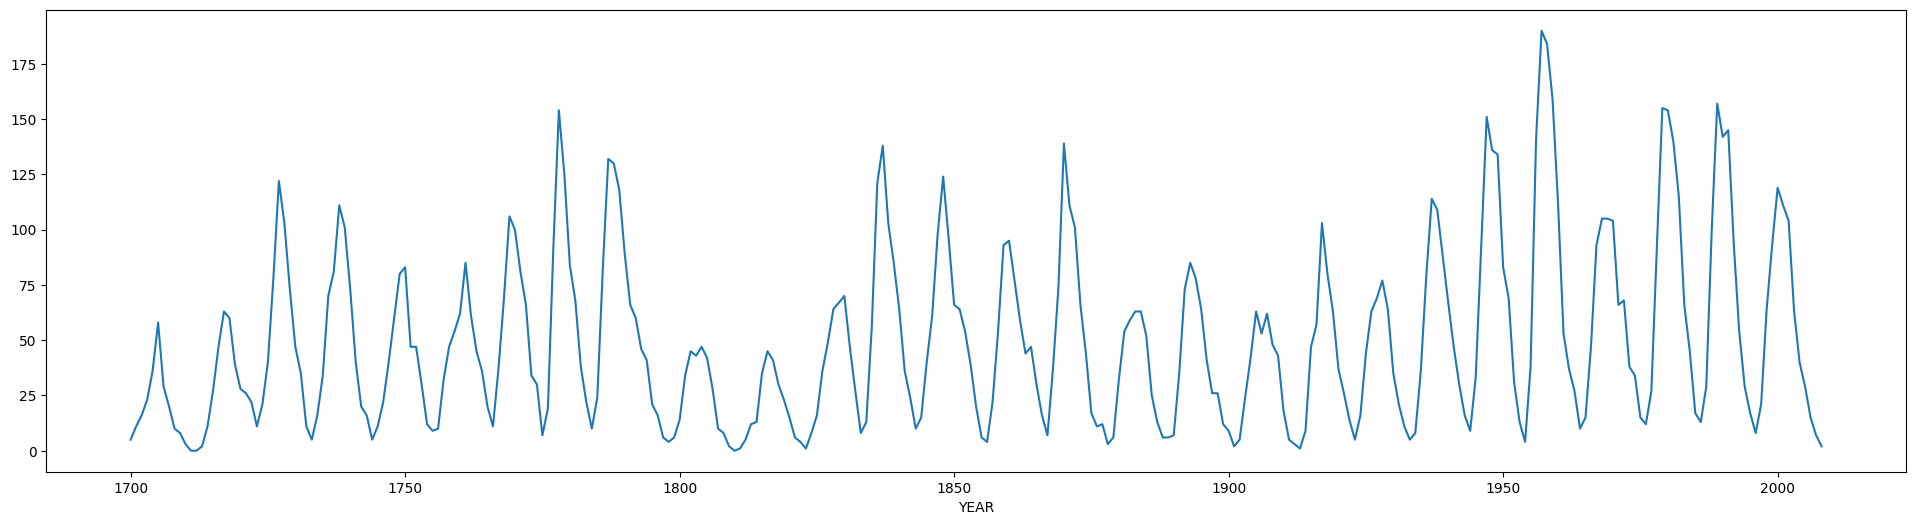

In [4]:
sspot['SUNACTIVITY'].plot(figsize=(24,6));

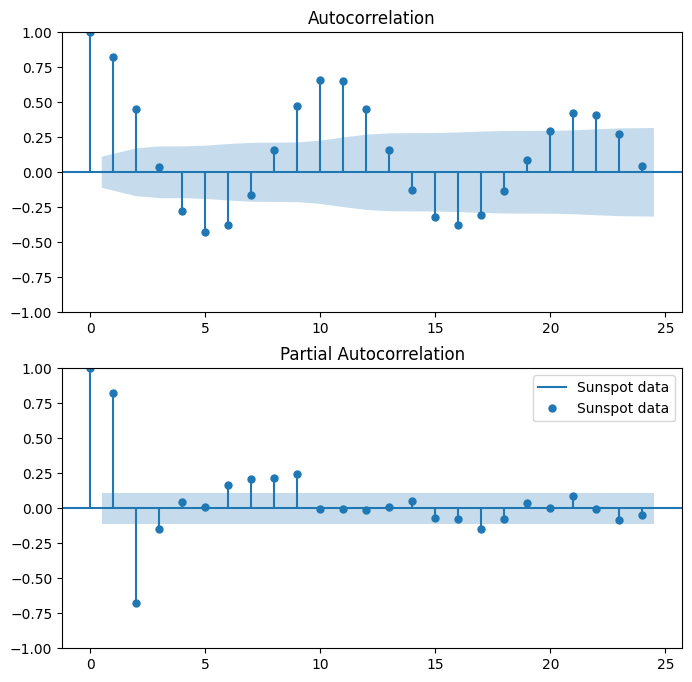

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
plot_acf(sspot, lags=24, ax=ax1, label='Sunspot data')
plot_pacf(sspot, lags=24, ax=ax2, label='Sunspot data')
ax2.legend();

Model the joint distribution of lag-0 to lag-7 values:

In [6]:
p = 9
X_raw = pd.concat([sspot[['SUNACTIVITY']].shift(i).add_suffix(f'-{i}') for i in range(p, -1, -1)], axis=1).dropna()
print(X_raw.shape)
X_raw.head()

(300, 10)


,SUNACTIVITY-9,SUNACTIVITY-8,SUNACTIVITY-7,SUNACTIVITY-6,SUNACTIVITY-5,SUNACTIVITY-4,SUNACTIVITY-3,SUNACTIVITY-2,SUNACTIVITY-1,SUNACTIVITY-0
YEAR,,,,,,,,,,
1709,5.0,11.0,16.0,23.0,36.0,58.0,29.0,20.0,10.0,8
1710,11.0,16.0,23.0,36.0,58.0,29.0,20.0,10.0,8.0,3
1711,16.0,23.0,36.0,58.0,29.0,20.0,10.0,8.0,3.0,0
1712,23.0,36.0,58.0,29.0,20.0,10.0,8.0,3.0,0.0,0
1713,36.0,58.0,29.0,20.0,10.0,8.0,3.0,0.0,0.0,2


Note also that since this is a count model, need to do a transformation to prevent modelling negative numbers.

In [7]:
X = np.sqrt(X_raw)

Visualise dependence structure:

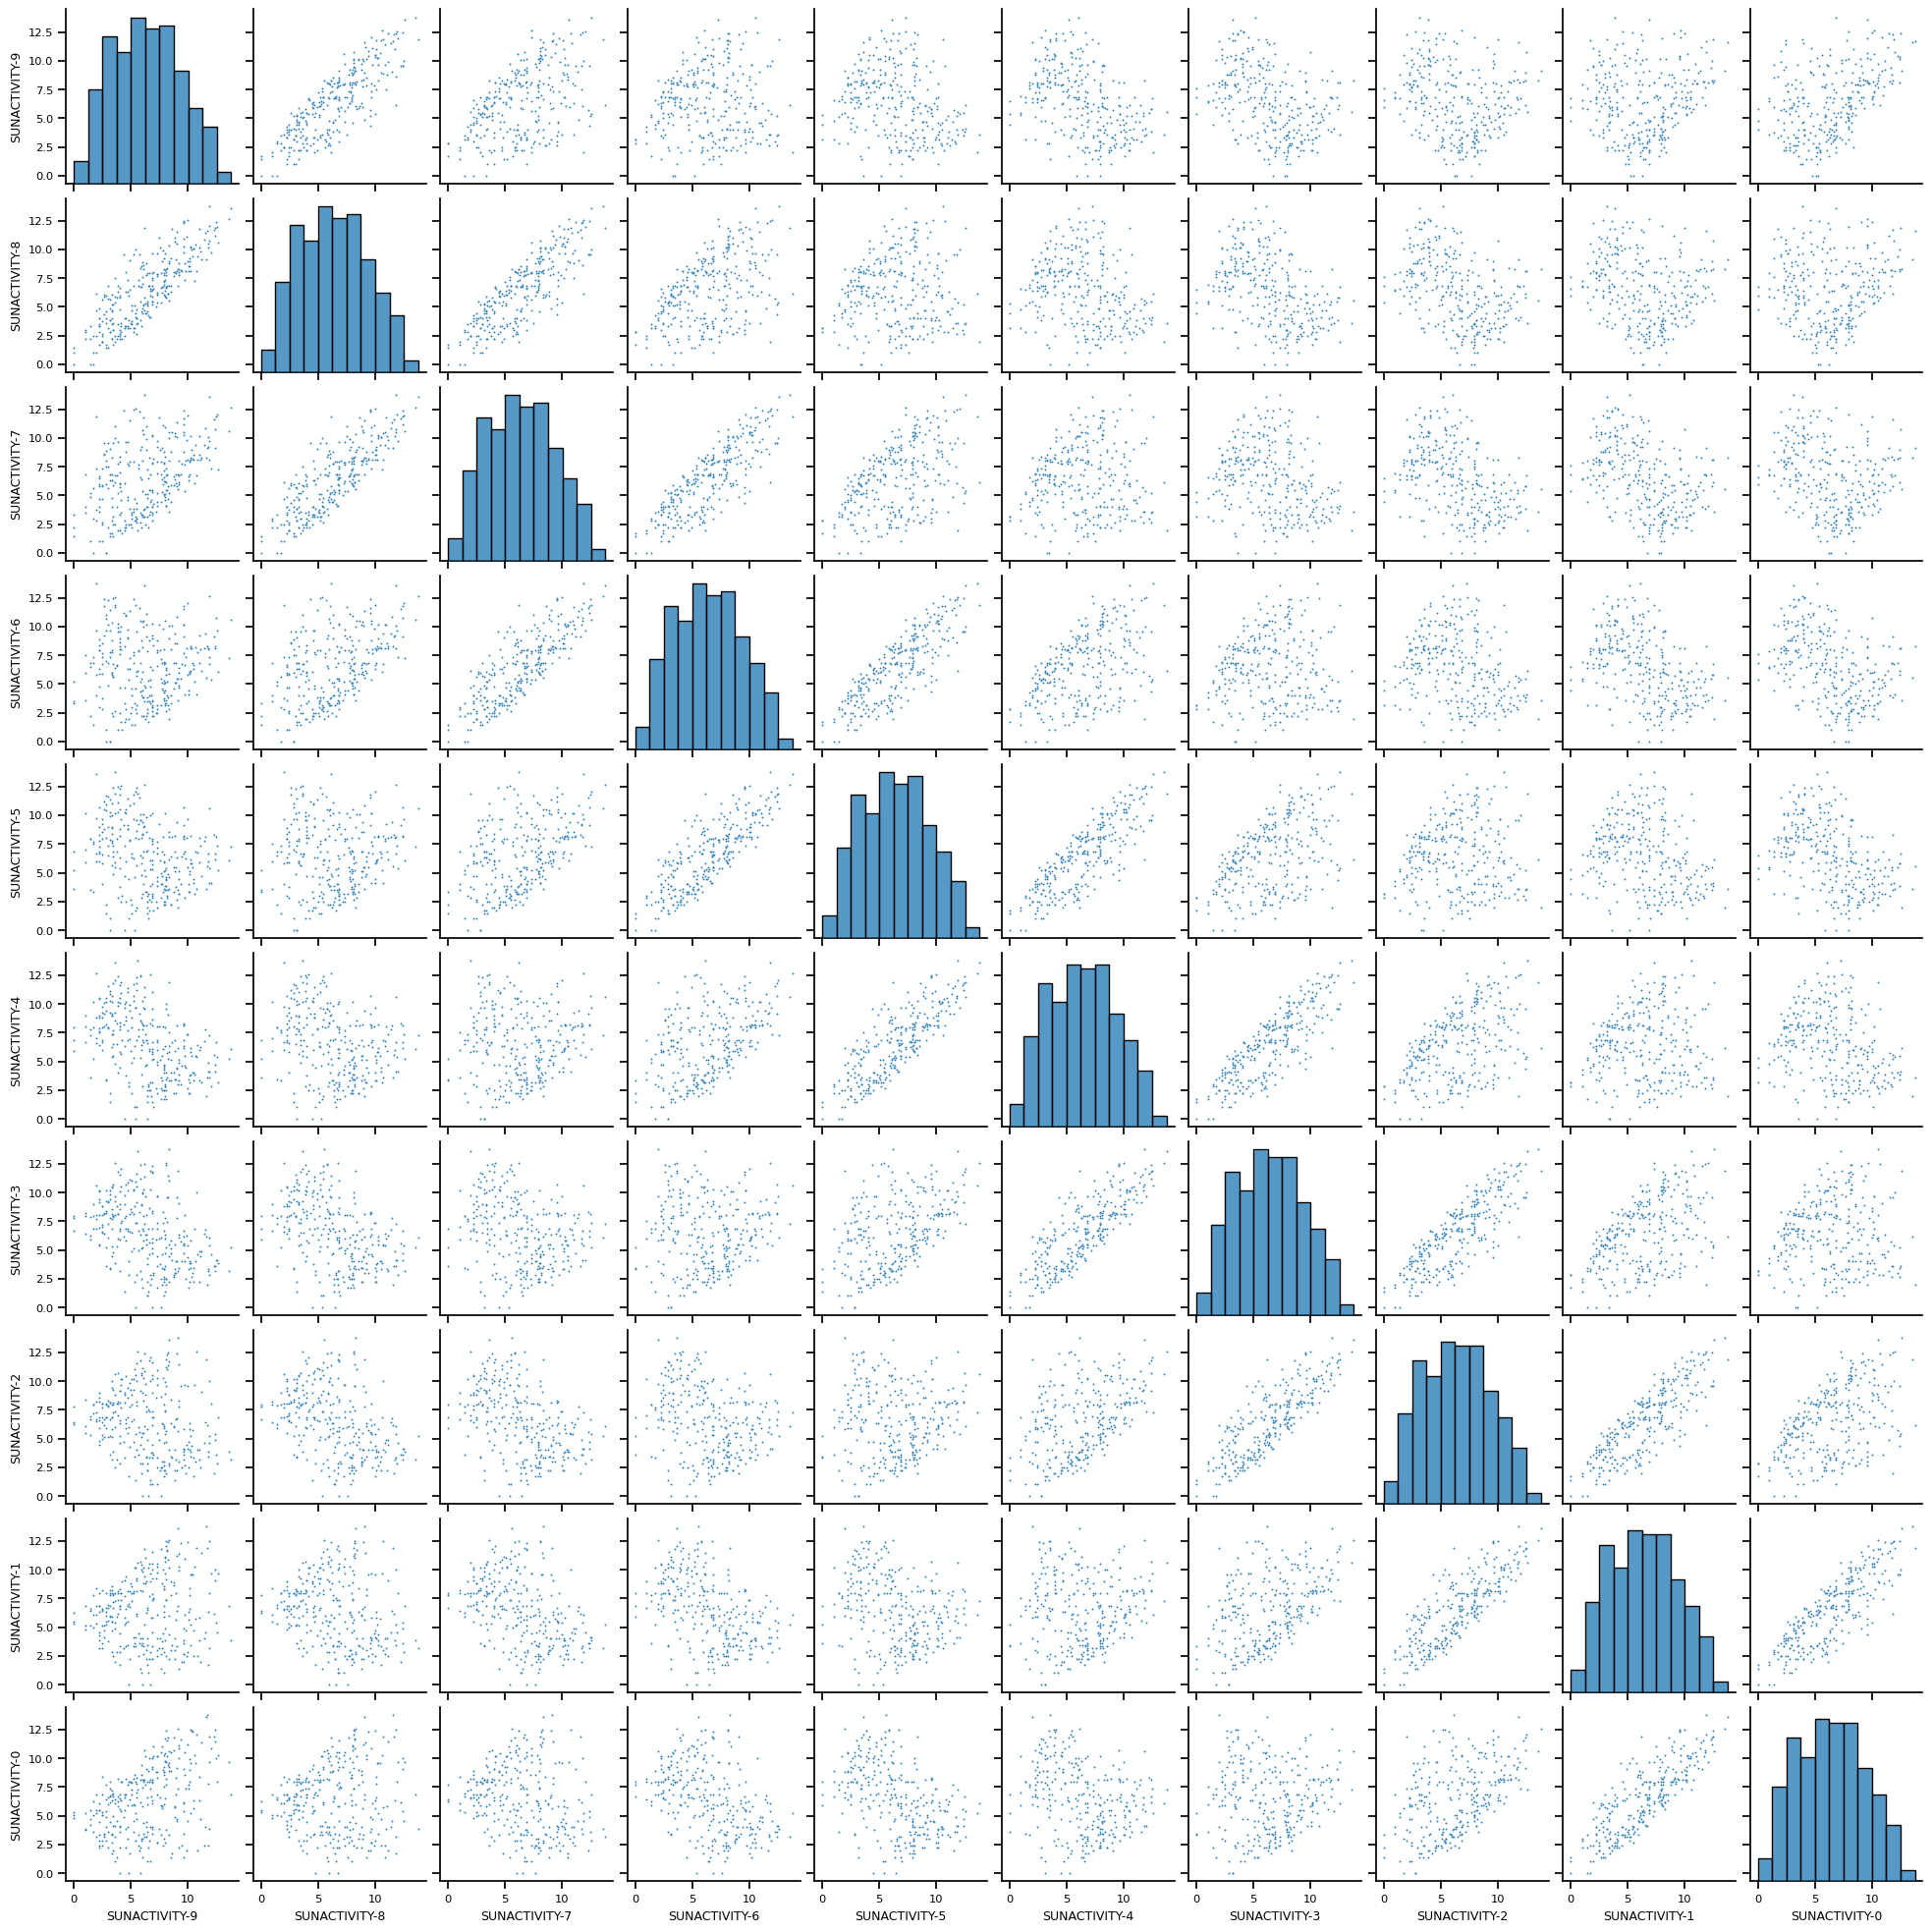

In [8]:
sns.set_context('notebook', font_scale=0.75)
sns.pairplot(X, height=2, plot_kws={'s': 2});

#### Fit GMM model to data and simulate

In [9]:
cov_type='full'

3


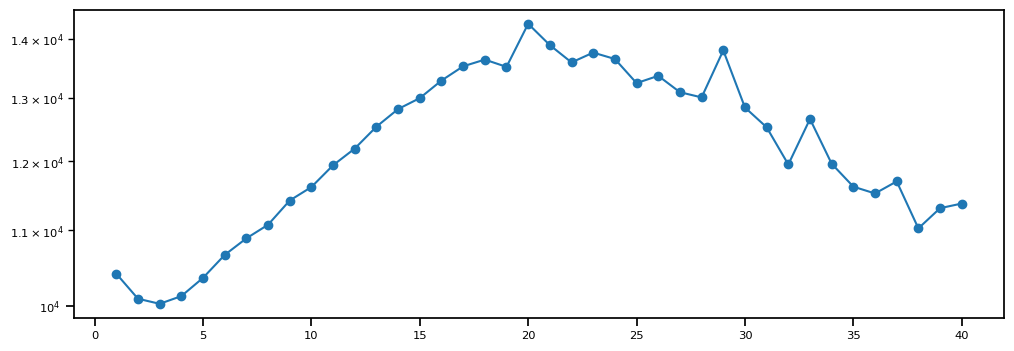

In [10]:
nk = 40
bics = np.zeros(nk)
ks = range(1, nk+1)
for i, k in enumerate(ks):
    gmm = GaussianMixture(n_components=k, covariance_type=cov_type).fit(X)
    bics[i] = gmm.bic(X)
k = bics.argmin() + 1
print(k)
plt.figure(figsize=(12,4))
plt.semilogy(ks, bics, marker='o');

In [11]:
gmm = GaussianMixture(n_components=k, covariance_type=cov_type).fit(X)

Define an array to store the results and populate with the initial values from the training data

In [12]:
# Data index at which to start simulating
ix0 = 0

# Ensemble members M and time steps N to simulate
M, N = 1000, sspot.shape[0] - ix0
#M, N = 1000, 50

# Create array to store simulations and populate first p time steps
sims = np.zeros((M, N))
sims[:,:p] = X.values[ix0,:p]

# Run time-stepping loop
np.random.seed()
for i in tqdm(range(p, N)):
    x_cond = np.vstack([sims[:,i-j] for j in range(p, 0, -1)]).T
    sims[:,i] = gmm.conditional_sample(x_cond=x_cond, dims_cond=range(p), lam=1e-2)[:,0]

# Reverse the square root transformation
sims = sims**2

# Calculate mean of all simulations, and 33rd and 66th percentiles
sims_q33 = pd.DataFrame(np.quantile(sims, 0.33, axis=0), columns=sspot.columns).add_suffix('_33rd')
sims_q50 = pd.DataFrame(np.quantile(sims, 0.5, axis=0), columns=sspot.columns).add_suffix('_median')
sims_q66 = pd.DataFrame(np.quantile(sims, 0.66, axis=0), columns=sspot.columns).add_suffix('_66th')

# Show summary statistics
summstats = pd.DataFrame([sspot['SUNACTIVITY'].describe().rename('orig'), 
                          pd.Series(sims.ravel(), name='sim').describe()])
summstats

  0%|          | 0/300 [00:00<?, ?it/s]

,count,mean,std,min,25%,50%,75%,max
orig,309.0,49.368932,40.405571,0.000000e+00,16.000000,40.000000,69.00000,190.000000
sim,309000.0,47.360922,37.561099,1.861965e-08,17.686324,39.279276,69.40277,492.243154


##### Visualise the simulated results

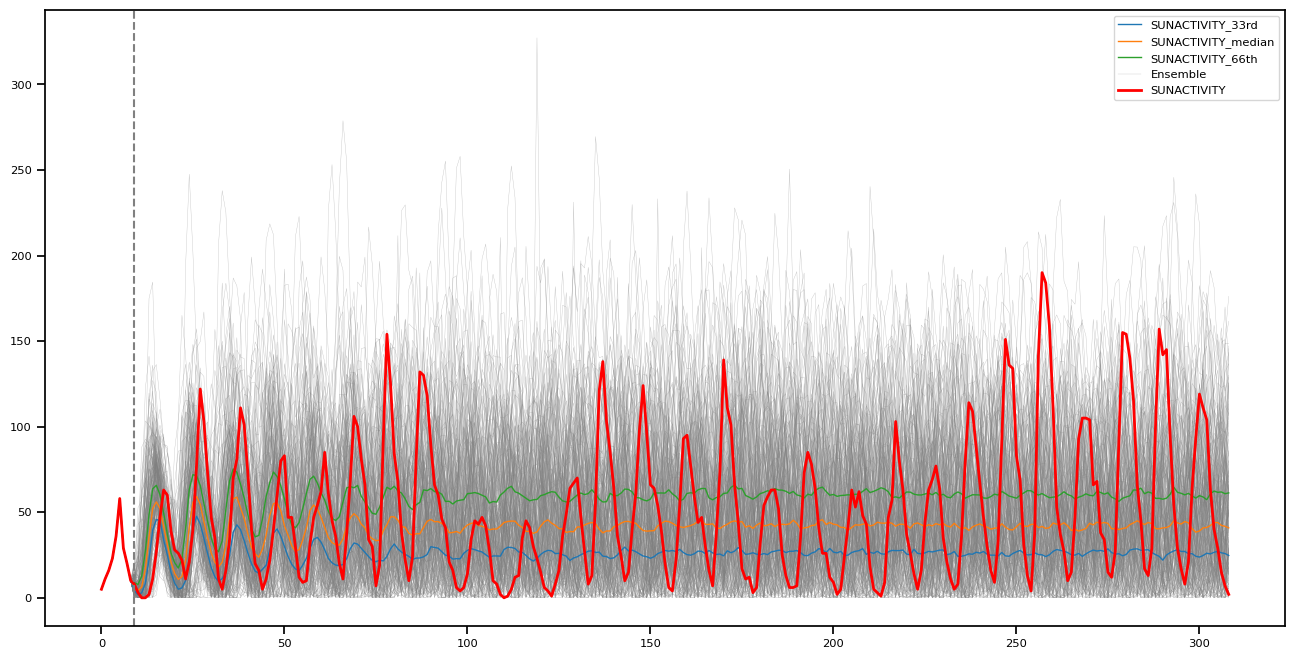

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(16,8))

sims_q33.plot(ax=ax, ls='-', lw=1, label='33rd percentile')
sims_q50.plot(ax=ax, ls='-', lw=1, label='median')
sims_q66.plot(ax=ax, ls='-', lw=1, label='66th percentile')

for i in range(min(M, 200)):
    ax.plot(sims[i], color='0.5', lw=0.25, zorder=-3, alpha=0.5, label='Ensemble' if i==0 else None)

sspot.iloc[ix0:ix0+N].reset_index(drop=True).plot(ax=ax, lw=2, color='r', label='Actual data')
ax.axvline(p, color='0.5', ls='--')
ax.legend();

##### Compare full and partial autocorrelations of input data and specific realisations

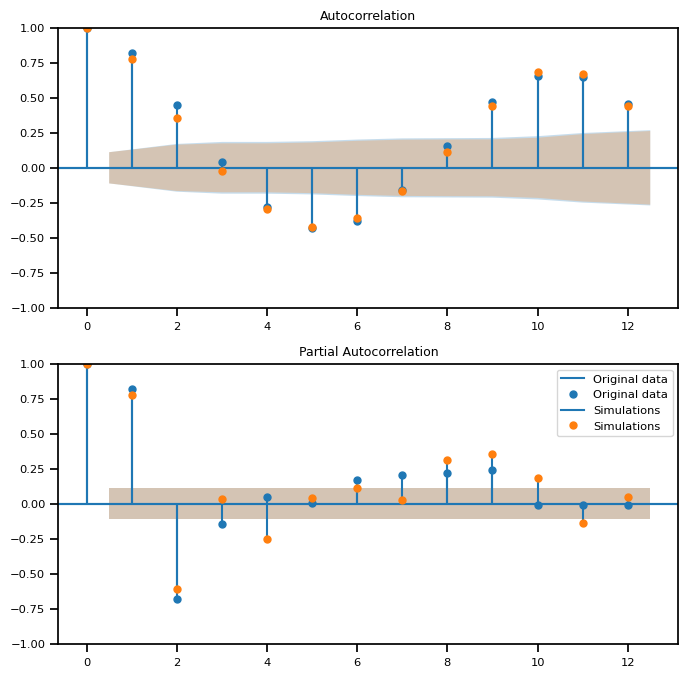

In [14]:
i = 42
nlags = 12
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
plot_acf(sspot, lags=nlags, ax=ax1, label='Original data')
plot_acf(sims[i], lags=nlags, ax=ax1, label='Simulations')
plot_pacf(sspot, lags=nlags, ax=ax2, label='Original data')
plot_pacf(sims[i], lags=nlags, ax=ax2, label='Simulations')
ax2.legend();

##### Compare ECDFs

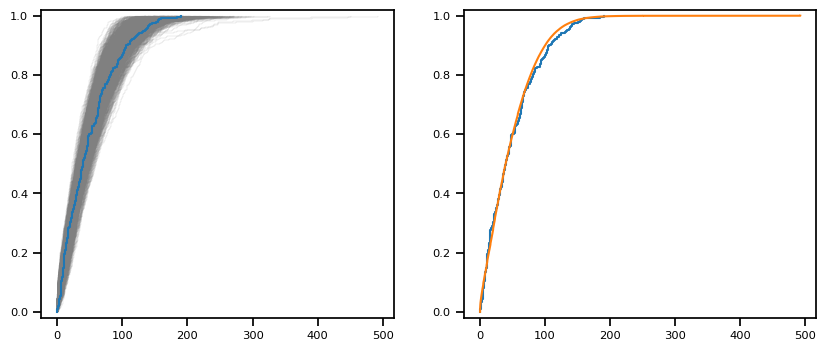

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.ecdf(sspot['SUNACTIVITY'], label='orig')
for i in range(sims.shape[0]):
    ax1.ecdf(sims[i], lw=0.1, color='0.5', zorder=-3)
ax1.set_ylim((-0.02, 1.02))

ax2.ecdf(sspot['SUNACTIVITY'], label='orig')
ax2.ecdf(sims.ravel())
ax2.set_ylim((-0.02, 1.02));

#### Now do the same process but using `scsgmm`

Note that it's no longer necessary to create the lagged matrix - just feed in the time series (possibly multivariate) and define the dependency graph.

In [16]:
ordern = 9
model = SCSGMM(ordern=ordern)

Transform the data to ensure positivity:

In [17]:
X = np.sqrt(sspot[['SUNACTIVITY']])
X

,SUNACTIVITY
YEAR,
1700,2.236068
1701,3.316625
1702,4.000000
1703,4.795832
1704,6.000000
...,...
2004,6.324555
2005,5.385165
2006,3.872983


Define the dependency graph. This takes form of a dictionary with keys `(periods, variables)` and values `[variables]`. In this case, with one variable and one period, the variable can only depend on itself, and the dependency graph `depn` is very simple:

In [18]:
depn = {(0, 0): [0]}
depn

{(0, 0): [0]}

Fit the model:

In [19]:
model.fit(X.values, depn)

  0%|          | 0/1 [00:00<?, ?it/s]

Define number of batches to simulate - this defines the shape of `X0`:

In [20]:
n_batches = 1000

Define initial values, consistent with the order of the model:

In [21]:
X0 = np.tile(X.values[:ordern], (n_batches,1,1))
X0.shape

(1000, 9, 1)

In [22]:
sims = model.simulate(Nt=300, X0=X0, seed=None)**2
sims.shape

  0%|          | 0/291 [00:00<?, ?it/s]

(1000, 300, 1)

In [23]:
# Calculate median, 33rd and 66th percentiles
sims_q33 = pd.DataFrame(np.quantile(sims, 0.33, axis=0), columns=sspot.columns).add_suffix('_33rd')
sims_q50 = pd.DataFrame(np.quantile(sims, 0.5, axis=0), columns=sspot.columns).add_suffix('_median')
sims_q66 = pd.DataFrame(np.quantile(sims, 0.66, axis=0), columns=sspot.columns).add_suffix('_66th')

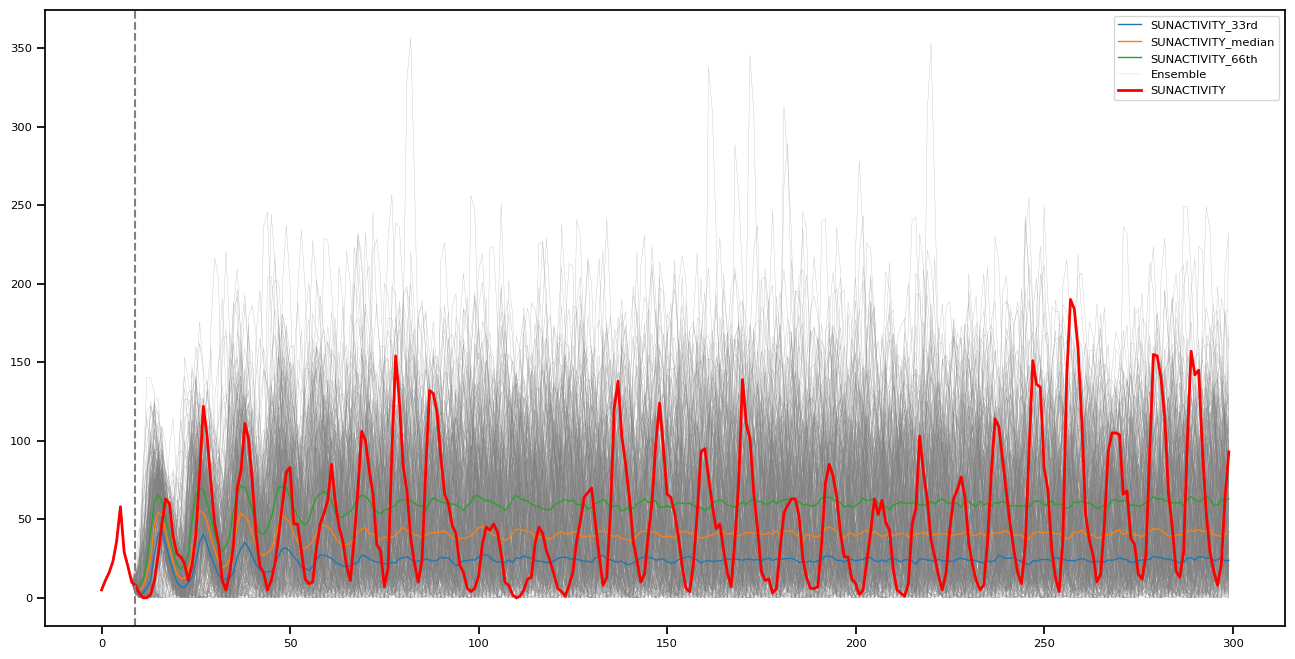

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(16,8))

sims_q33.plot(ax=ax, ls='-', lw=1, label='33rd percentile')
sims_q50.plot(ax=ax, ls='-', lw=1, label='median')
sims_q66.plot(ax=ax, ls='-', lw=1, label='66th percentile')

for i in range(sims.shape[1]):
    ax.plot(sims[i], color='0.5', lw=0.25, zorder=-3, alpha=0.5, label='Ensemble' if i==0 else None)

sspot.iloc[:sims.shape[1]].reset_index(drop=True).plot(ax=ax, lw=2, color='r', label='Actual data')
ax.axvline(p, color='0.5', ls='--')
ax.legend();